# Chapter 6 – Decision Trees
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alirezatheh/handson-ml3-notes/blob/main/notebooks/06_decision_trees.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/alirezatheh/handson-ml3-notes/blob/main/notebooks/06_decision_trees.ipynb)

## Training and Visualizing a Decision Tree
To understand decision trees, let’s build one and take a look at how it makes predictions:

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[['petal length (cm)', 'petal width (cm)']].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

Let’s visualize the trained decision tree:

In [2]:
from pathlib import Path

from sklearn.tree import export_graphviz

IMAGES_PATH = Path().parent / 'images' / '06'
export_graphviz(
    tree_clf,
    out_file=str(IMAGES_PATH / 'iris_tree.dot'),
    feature_names=['petal length (cm)', 'petal width (cm)'],
    class_names=iris.target_names,
    rounded=True,
    filled=True,
)

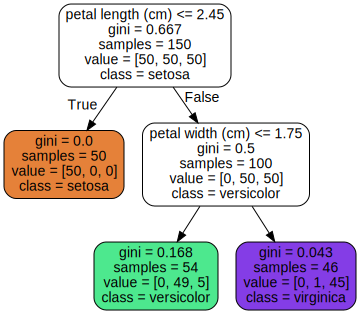

In [3]:
from graphviz import Source

Source.from_file(str(IMAGES_PATH / 'iris_tree.dot'))

Graphviz also provides the `dot` command line tool to convert `.dot` files to a variety of formats. The following command converts the dot file to a png image:

In [4]:
!dot -Tpng {IMAGES_PATH / 'iris_tree.dot'} -o {IMAGES_PATH / 'iris_tree.png'}

## Making Predictions
We starts at the *root* node and traverse the tree until we reach to a *leaf* node.
- `samples`: Counts how many training instances the node applies to.
- `values`: Tells us how many training instances of each class the node applies to.
- `gini`: Measures its *Gini impurity*: a node is “pure” (`gini=0`) if all training instances it applies to belong to the same class.

  **Equation 6-1** Gini impurity
  $$
  G_i=1-\sum_{k=1}^n{p_{i,k}}^2
  $$
  - $G_i$: The Gini impurity of the $i^{\text{th}}$ node.
  - $p_{i,k}$: The ratio of class $k$ instances among the training instances in the $i^{\text{th}}$ node.

**Note**: Decision trees require very little data preparation. In fact, they don’t require feature scaling or centering at all.

**Note**: Scikit-Learn uses the CART algorithm, which produces only *binary trees*. Other algorithms, such as ID3, can produce decision trees with nodes that have more than two children.

We can access the tree structure via the `tree_` attribute:

In [5]:
tree_clf.tree_

<div style="border: 1px solid;">

### Model Interpretation: White Box Versus Black Box
Models that are intuitive, and their decisions are easy to interpret, are often called *white box models* (e.g. decision trees). With other modes it is usually hard to explain in simple terms why the predictions were made, these models are generally considered *black box models* (e.g. random forest and neural networks). The field of *interpretable ML* aims at creating ML systems that can explain their decisions in a way humans can understand. This is important in many domains, e.g. to ensure the system does not make unfair decisions.
</div>

## Estimating Class Probabilities
To estimate the probability that an instance belongs to a particular class $k$, the decision tree traverses the tree to find the leaf node for that instance, and then it returns the ratio of training instances of class $k$ in this node.

In [6]:
tree_clf.predict_proba([[5, 1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [7]:
tree_clf.predict([[5, 1.5]])

array([1])

## The CART Training Algorithm
The *Classification and Regression Tree* (CART) algorithm (also called “growing” trees) works by first splitting the training set into two subsets using a single feature $k$ and a threshold $t_k$. It searches for the pair ($k$, $t_k$) that produces the purest subsets, weighted by their size. Here is the cost function that the algorithm tries to minimize.

**Equation 6-2** CART cost function for classification
$$
J(k, t_k)
=\frac{m_{\text{left}}}{m}G_{\text{left}}
+\frac{m_{\text{right}}}{m}G_{\text{tight}}
$$
- $G_{\text{left/right}}$: Measures the impurity of the left/right subset.
- $m_{\text{left/right}}$: The number of instances in the left/right subset

CART splits recursively until it reaches to the maximum depth, or if it cannot find a split that will reduce impurity. There is other stopping conditions.

**Warning**: The CART algorithm is a *greedy algorithm*. Finding the optimal tree is known to be an *NP-complete* problem and requires $O(\exp(m))$ time.

**Note**: P is the set of problems that can be solved in *polynomial time* (i.e., a polynomial of the dataset size). NP is the set of problems whose solutions can be verified in polynomial time. An NP-hard problem is a problem that can be reduced to a known NP-hard problem in polynomial time. An NP-complete problem is both NP and NP-hard. A major open mathematical question is whether P = NP or not. If P ≠ NP (which seems likely), then no polynomial algorithm will ever be found for any NP-complete problem (except perhaps one day on a quantum computer).

## Computational Complexity
- Prediction: $O(\log_2(m))$ since it requires traversing from the root to a leaf and decision trees generally are approximately balanced, and each node only requires checking the value of one feature.
- Training: $O(n\times m\log_2(m))$ since it compares all features on all samples at each node.

## Gini Impurity or Entropy?
*Entropy* is zero for a set when it contains instances of only one class.

**Equation 6-3** Entropy
$$
H_i
=-\sum_{\begin{gathered}k=1\\p_{i,k}\neq 0\end{gathered}}^n
p_{i,k}\log_2(p_{i,k})
$$

In Scikit-Learn we can set `criterion='entropy'`.

Which one to use? Gini impurity is slightly faster to compute and tends to isolate the most frequent class in its own branch of the tree, while entropy tends to produce slightly more balanced trees (See Sebastian Raschka’s [interesting analysis](https://homl.info/19) for more details).

## Regularization Hyperparameters
Decision tree is a *nonparametric model* i.e number of parameters is not determined prior to training. To avoid overfitting the training data, we need to restrict it. The `DecisionTreeClassifier` class has a few parameters that restrict the shape of the decision tree:
- `max_depth`: The default value is None, which means unlimited.
- `max_features`: Maximum number of features that are evaluated for splitting at each node
- `max_leaf_nodes`: Maximum number of leaf nodes
- `min_samples_split`: Minimum number of samples a node must have before it can be split
- `min_samples_leaf`: Minimum number of samples a leaf node must have to be created
- `min_weight_fraction_leaf`: Same as `min_samples_leaf` but expressed as a fraction of the total number of weighted instances

Increasing `min_*` hyperparameters or reducing `max_*` hyperparameters will regularize the model.

**Note**: Other algorithms work by first training the decision tree without restrictions, then *pruning* (deleting) unnecessary nodes. A node whose children are all leaf nodes is considered unnecessary if the purity improvement it provides is not statistically significant. Standard statistical tests, such as the $\chi^2$ test (chi-squared test), are used to estimate the probability that the improvement is purely the result of chance (which is called the *null hypothesis*). If this probability, called the *p-value*, is higher than a given threshold (typically 5%, controlled by a hyperparameter), then the node is considered unnecessary and its children are deleted. The pruning continues until all unnecessary nodes have been pruned.

Let’s test regularization on the moons dataset:

In [8]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

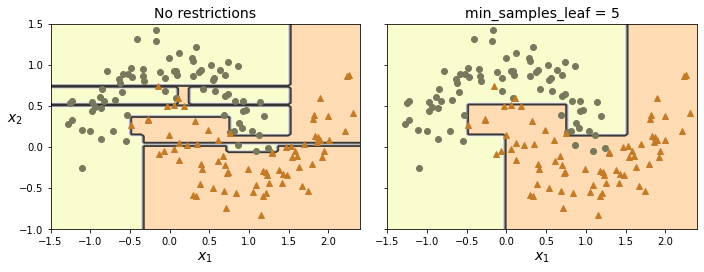

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


def plot_decision_boundary(
    clf: Pipeline, X: np.ndarray, y: np.ndarray, axes: list[float], cmap: str
) -> None:
    x1, x2 = np.meshgrid(
        np.linspace(axes[0], axes[1], 100), np.linspace(axes[2], axes[3], 100)
    )
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap='Greys', alpha=0.8)
    colors = {'Wistia': ['#78785c', '#c47b27'], 'Pastel1': ['red', 'blue']}
    markers = ('o', '^')
    for idx in (0, 1):
        plt.plot(
            X[:, 0][y == idx],
            X[:, 1][y == idx],
            color=colors[cmap][idx],
            marker=markers[idx],
            linestyle='none',
        )
    plt.axis(axes)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$', rotation=0)


fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(
    tree_clf1, X_moons, y_moons, axes=[-1.5, 2.4, -1, 1.5], cmap='Wistia'
)
plt.title('No restrictions')
plt.sca(axes[1])
plot_decision_boundary(
    tree_clf2, X_moons, y_moons, axes=[-1.5, 2.4, -1, 1.5], cmap='Wistia'
)
plt.title(f'min_samples_leaf = {tree_clf2.min_samples_leaf}')
plt.ylabel('')
plt.show()

In [10]:
X_moons_test, y_moons_test = make_moons(
    n_samples=1000, noise=0.2, random_state=43
)
tree_clf1.score(X_moons_test, y_moons_test)

0.898

In [11]:
tree_clf2.score(X_moons_test, y_moons_test)

0.92

## Regression
Let’s build a regression tree:

In [12]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
# A single random input feature
X_quad = np.random.rand(200, 1) - 0.5
y_quad = X_quad**2 + 0.025 * np.random.randn(200, 1)

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=2, random_state=42)

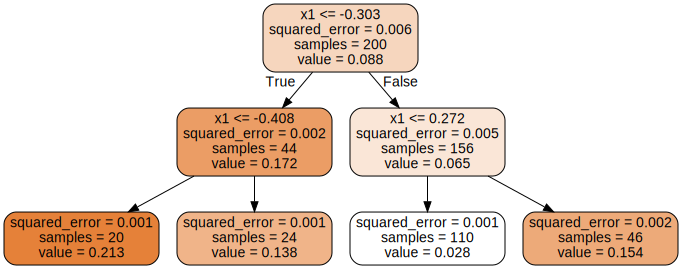

In [13]:
export_graphviz(
    tree_reg,
    out_file=str(IMAGES_PATH / 'regression_tree.dot'),
    feature_names=['x1'],
    rounded=True,
    filled=True,
)
Source.from_file(IMAGES_PATH / 'regression_tree.dot')

In [14]:
tree_reg2 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg2.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [15]:
tree_reg.tree_.threshold

array([-0.30265072, -0.40830374, -2.        , -2.        ,  0.27175756,
       -2.        , -2.        ])

In [16]:
tree_reg2.tree_.threshold

array([-0.30265072, -0.40830374, -0.45416115, -2.        , -2.        ,
       -0.37022041, -2.        , -2.        ,  0.27175756, -0.21270403,
       -2.        , -2.        ,  0.40399227, -2.        , -2.        ])

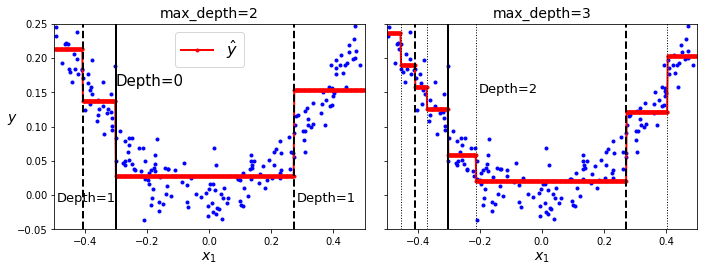

In [17]:
def plot_regression_predictions(
    tree_reg: Pipeline,
    X: np.ndarray,
    y: np.ndarray,
    axes: list[float] = [-0.5, 0.5, -0.05, 0.25],
) -> None:
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel('$x_1$')
    plt.plot(X, y, 'b.')
    plt.plot(x1, y_pred, 'r.-', linewidth=2, label=r'$\hat{y}$')


fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg, X_quad, y_quad)

th0, th1a, th1b = tree_reg.tree_.threshold[[0, 1, 4]]
for split, style in ((th0, 'k-'), (th1a, 'k--'), (th1b, 'k--')):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
plt.text(th0, 0.16, 'Depth=0', fontsize=15)
plt.text(
    th1a + 0.01, -0.01, 'Depth=1', horizontalalignment='center', fontsize=13
)
plt.text(th1b + 0.01, -0.01, 'Depth=1', fontsize=13)
plt.ylabel('$y$', rotation=0)
plt.legend(loc='upper center', fontsize=16)
plt.title('max_depth=2')

plt.sca(axes[1])
th2s = tree_reg2.tree_.threshold[[2, 5, 9, 12]]
plot_regression_predictions(tree_reg2, X_quad, y_quad)
for split, style in ((th0, 'k-'), (th1a, 'k--'), (th1b, 'k--')):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
for split in th2s:
    plt.plot([split, split], [-0.05, 0.25], 'k:', linewidth=1)
plt.text(th2s[2] + 0.01, 0.15, 'Depth=2', fontsize=13)
plt.title('max_depth=3')

plt.show()

The CART algorithm works as earlier, except that instead of trying to split in a way that minimizes impurity, it now tries to split in a way that minimizes the MSE.

**Equation 6-4** CART cost function for regression
$$
J(k, t_k)
=\frac{m_{\text{left}}}{m}\text{MSE}_{\text{left}}
+\frac{m_{\text{right}}}{m}\text{MSE}_{\text{tight}}
\;\text{where}\;\begin{dcases}
\text{MSE}_\text{node}
=\frac{\sum_{i\in\text{node}}\left(\widehat{y}_\text{node}-y^{(i)}\right)^2}
{m_\text{node}}
\\\\\widehat{y}_\text{node}=\frac{\sum_{i\in\text{node}}y^{(i)}}{m_\text{node}}
\end{dcases}
$$

## Sensitivity to Axis Orientation
Rotating the dataset leads to completely different decision boundaries:

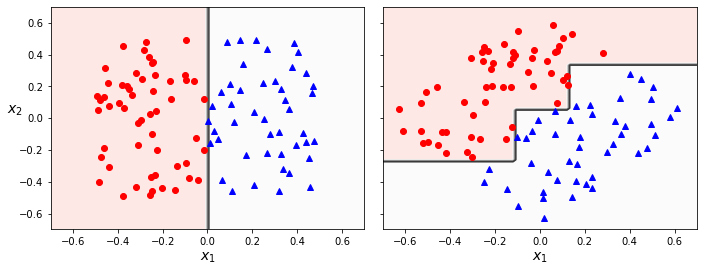

In [18]:
np.random.seed(6)
X_square = np.random.rand(100, 2) - 0.5
y_square = (X_square[:, 0] > 0).astype(np.int64)

# 45 degrees
angle = np.pi / 4
rotation_matrix = np.array(
    [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
)
X_rotated_square = X_square.dot(rotation_matrix)

tree_clf_square = DecisionTreeClassifier(random_state=42)
tree_clf_square.fit(X_square, y_square)
tree_clf_rotated_square = DecisionTreeClassifier(random_state=42)
tree_clf_rotated_square.fit(X_rotated_square, y_square)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(
    tree_clf_square,
    X_square,
    y_square,
    axes=[-0.7, 0.7, -0.7, 0.7],
    cmap='Pastel1',
)
plt.sca(axes[1])
plot_decision_boundary(
    tree_clf_rotated_square,
    X_rotated_square,
    y_square,
    axes=[-0.7, 0.7, -0.7, 0.7],
    cmap='Pastel1',
)
plt.ylabel('')

plt.show()

One way to limit this problem is to scale the data, then apply a principal component analysis transformation. We will look at PCA in detail in Chapter 8 but for now know that it rotates the data in a way that reduces the correlation between the features, which often (not always) makes things easier for trees:

In [19]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pca_pipeline = make_pipeline(StandardScaler(), PCA())
X_iris_rotated = pca_pipeline.fit_transform(X_iris)
tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_pca.fit(X_iris_rotated, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

Here is the diffrence:
<style scoped>td {border: none !important;}</style>
<table align="center">
  <td>
    <img 
      src="../images/06/iris_decision_boundary.png" 
      onerror="
        this.onerror = null;
        const repo = 'https://github.com/alirezatheh/handson-ml3-notes/blob/main';
        this.src = repo + this.src.split('..')[1];
      "
    >
  </td>
  <td>
    <img 
      src="../images/06/iris_pca_decision_boundary.png" 
      onerror="
        this.onerror = null;
        const repo = 'https://github.com/alirezatheh/handson-ml3-notes/blob/main';
        this.src = repo + this.src.split('..')[1];
      "
    >
  </td>
  <tr>
    <td align="center">Original Iris dataset</td>
    <td align="center">PCA Tranformed Iris dataset</td>
  </tr>
</table>

## Decision Trees Have a High Variance
The main issue with decision trees is that they have quite a high variance: small changes to the hyperparameters or to the data may produce very different models. Scikit-Learn’s algorithm is stochastic (it randomly selects the set of features to evaluate at each node) even retraining the same decision tree on the exact same data may produce a very different model (unless we set the `random_state` hyperparameter). To solve this issue we can average predictions over many trees. By doing this we can reduce variance significantly. Such an *ensemble* of trees is called a *random forest*.

## Extra Material - Accessing The Tree Structure
A trained `DecisionTreeClassifier` has a `tree_` attribute that stores the tree’s structure:

In [20]:
tree = tree_clf.tree_
tree

We can get the total number of nodes in the tree:

In [21]:
tree.node_count

5

And other self-explanatory attributes are available:

In [22]:
tree.max_depth

2

In [23]:
tree.max_n_classes

3

In [24]:
tree.n_features

2

In [25]:
tree.n_outputs

1

In [26]:
tree.n_leaves

3

All the information about the nodes is stored in NumPy arrays.

In [27]:
tree.impurity

array([0.66666667, 0.        , 0.5       , 0.16803841, 0.04253308])

The root node is at index 0. The left and right children nodes of node *i* are `tree.children_left[i]` and `tree.children_right[i]`.

In [28]:
tree.children_left[0], tree.children_right[0]

(1, 2)

When the left and right nodes are equal, it means this is a leaf node (and the children node ids are arbitrary):

In [29]:
tree.children_left[3], tree.children_right[3]

(-1, -1)

So we can get the leaf node ids like this:

In [30]:
is_leaf = tree.children_left == tree.children_right
np.arange(tree.node_count)[is_leaf]

array([1, 3, 4])

Non-leaf nodes are called *split nodes*. The feature they split is available via the `feature` array. Values for leaf nodes should be ignored:

In [31]:
tree.feature

array([ 0, -2,  1, -2, -2], dtype=int64)

And the corresponding thresholds are:

In [32]:
tree.threshold

array([ 2.44999999, -2.        ,  1.75      , -2.        , -2.        ])

And the number of instances per class that reached each node is available too:

In [33]:
tree.value

array([[[50., 50., 50.]],

       [[50.,  0.,  0.]],

       [[ 0., 50., 50.]],

       [[ 0., 49.,  5.]],

       [[ 0.,  1., 45.]]])

In [34]:
tree.n_node_samples

array([150,  50, 100,  54,  46], dtype=int64)

In [35]:
np.all(tree.value.sum(axis=(1, 2)) == tree.n_node_samples)

True

Here’s how we can compute the depth of each node:

In [36]:
def compute_depth(tree_clf: Pipeline) -> np.ndarray:
    tree = tree_clf.tree_
    depth = np.zeros(tree.node_count)
    stack = [(0, 0)]
    while stack:
        node, node_depth = stack.pop()
        depth[node] = node_depth
        if tree.children_left[node] != tree.children_right[node]:
            stack.append((tree.children_left[node], node_depth + 1))
            stack.append((tree.children_right[node], node_depth + 1))
    return depth


depth = compute_depth(tree_clf)
depth

array([0., 1., 1., 2., 2.])

Here’s how to get the thresholds of all split nodes at depth 1:

In [37]:
tree_clf.tree_.feature[(depth == 1) & (~is_leaf)]

array([1], dtype=int64)

In [38]:
tree_clf.tree_.threshold[(depth == 1) & (~is_leaf)]

array([1.75])

For more information, check out this class’s documentation:

In [39]:
# help(sklearn.tree._tree.Tree)

## Exercises

### 1. to 7.
1. What is the approximate depth of a decision tree trained (without restrictions) on a training set with one million instances?
> The depth of a well-balanced binary tree containing $m$ leaves is equal to $\log_2(m)$, rounded up. A binary decision tree will end up more or less well balanced at the end of training, with one leaf per training instance if it is trained without restrictions. Thus, if the training set contains one million instances, the decision tree will have a depth of $\log_2(10^6)\approx20$ (actually a bit more since the tree will generally not be perfectly well balanced).
2. Is a node’s Gini impurity generally lower or higher than its parent’s? Is it *generally* lower/higher, or *always* lower/higher?
> Yes, This is due to the CART training algorithm’s cost function, which splits each node in a way that minimizes the weighted sum of its children’s Gini impurities. However, it is possible for a node to have a higher Gini impurity than its parent, as long as this increase is more than compensated for by a decrease in the other child’s impurity. e.g. consider a node containing four instances of class A and one of class B. Its Gini impurity is $1–(1/5)^2–(4/5)^2=0.32$. Now suppose the dataset is one-dimensional and the instances are lined up in the following order: A, B, A, A, A. We can verify that the algorithm will split this node after the second instance, producing one child node with instances A, B, and the other child node with instances A, A, A. The first child node’s Gini impurity is $1–(1/2)^2–(1/2)^2=0.5$, which is higher than its parent’s. This is compensated for by the fact that the other node is pure, so its overall weighted Gini impurity is $(2/5)\times0.5+(3/5)\times0=0.2$, which is lower than the parent’s Gini impurity.
3. If a decision tree is overfitting the training set, is it a good idea to try decreasing `max_depth`?
> It may be a good idea to decrease `max_depth`, since this will constrain the model, regularizing it.
4. If a decision tree is underfitting the training set, is it a good idea to try scaling the input features?
> Decision trees don’t care whether the training data is scaled or centered or not; that’s one of the nice things about them. So No.
5. If it takes one hour to train a decision tree on a training set containing one million instances, roughly how much time will it take to train another decision tree on a training set containing ten million instances? Hint: consider the CART algorithm’s computational complexity.
> The computational complexity of training a decision tree is $O(n\times m\log_2(m))$. So if we multiply the training set size by 10, the training time will be multiplied by $K=(n\times10m\times\log_2(10m))/(n\times m\times\log_2(m))=10\times\log_2(10m)/\log_2(m)$. If $m=10^6$, then $K≈11.7$, so we can expect the training time to be roughly 11.7 hours.
6. If it takes one hour to train a decision tree on a given training set, roughly how much time will it take if us double the number of features?
> If the number of features doubles, then the training time will also roughly double.
7. Train and fine-tune a decision tree for the moons dataset by following these steps:
   - **a.** Generate a moons dataset using `make_moons(n_samples=10000, noise=0.4)`.

In [40]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=10000, noise=0.4, random_state=42)

- **b.** Split it into a training set and a test set using `train_test_split()`.

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_moons, y_moons, test_size=0.2, random_state=42
)

- **c.** Use grid search with cross-validation (with the help of the`GridSearchCV` class) to find good hyperparameter values for a `DecisionTreeClassifier`. Hint: try various values for `max_leaf_nodes`.

In [42]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_leaf_nodes': list(range(2, 100)),
    'max_depth': list(range(1, 7)),
    'min_samples_split': [2, 3, 4],
}
grid_search_cv = GridSearchCV(
    DecisionTreeClassifier(random_state=42), params, cv=3
)

grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]})

In [43]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=17, random_state=42)

- **d.** Train it on the full training set using these hyperparameters, and measure our model’s performance on the test set. We should get roughly 85% to 87% accuracy.
> By default, `GridSearchCV` trains the best model found on the whole training set (we can change this by setting `refit=False`), so we don’t need to do it again. We can simply evaluate the model’s accuracy:

In [44]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8595

### 8.
Grow a forest by following these steps:
- **a.** Continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly. Hint: we can use Scikit-Learn’s `ShuffleSplit` class for this.

In [45]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(
    n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42
)

for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

- **b.** Train one decision tree on each subset, using the best hyperparameter values found above. Evaluate these 1,000 decision trees on the test set. Since they were trained on smaller sets, these decision trees will likely perform worse than the first decision tree, achieving only about 80% accuracy.

In [46]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)

    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.805671

- **c.** Now comes the magic. For each test set instance, generate the predictions of the 1,000 decision trees, and keep only the most frequent prediction (we can use SciPy’s `mode()` function for this). This gives us *majority-vote predictions* over the test set.

In [47]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [48]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

- **d.** Evaluate these predictions on the test set: we should obtain a slightly higher accuracy than our first model (about 0.5 to 1.5% higher). Congratulations, we have trained a random forest classifier!

In [49]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.873